### Notes for the project:

> #### Input: 
68 Key points <br>
68 * 2 cause we have (x,y) <br>
then `136` values (key points) for input (Features) <br>
Note that we can feature engineer it also and not take all features <br>
<br>

> #### Output:
3 Values so we can handle this in two approaches: <br><br>
1- First Is to use sklearn function to combine all three outputs together <br>
2- Second Use the same above function but with three diffrent models each for eacch angle (yo, pitch, roll)<br>
Example 136 features (Input) -> Model 1 -> Angle 1 (Output)
<br>
`Note`: input is keypoints and output is the angle <br>

> #### Keypoints: 
We will get the keypoints from the dataset `Don't` use the images directly <br>
The `annotations` is inside the dataset .mat file -> bt3d_68 (take x,y and neglecate z). <br>
When we finish we will use dlib with the same 68 key points

> #### Problems: 
`Problem 1:` Images of the training dataset and testing datasets have diffrernt scales and positions <br>
`Solution 1:` Is to normalize the points -> Select a pont and center the points around it.
<br>
`Example 1:` choose nose and subtract all points from nose that said the nose will be out (0,0)<br><br>
`Problem 2:` Size of the images and position of the faces vary.<br>
`Solution 2:` Choose any two points (nose and eyebrow) calculate the distance then divide all points in my image on that distance. `All Points / Distance` <br>
This makes the face size constant across all images (Training and Testing) 

> #### Updated!!:
There is an Issue using `dlib` so as an alternative we are gonna use `mediapipe`. <br>
We will use mediapipe to extract points in training and alos to extract points in testing time (video). <br>
That said mediapipe usage is to extract points only. 

### Imports 

In [22]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### Downloading Data

In [23]:
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

### Draw Axis

In [24]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Prepare Data

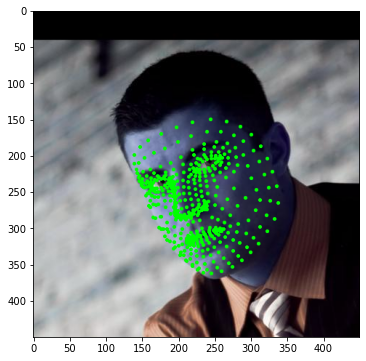

In [64]:
# choosing random image
random_file = 'image00020'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file

with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('./AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.show()

In [65]:
random_file

'image00020'

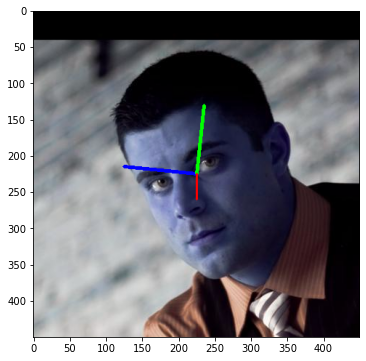

In [66]:
image = cv2.imread('./AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('./AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0] * 180 / np.pi
yaw = pose_para[1] * 180 / np.pi
roll = pose_para[2] * 180 / np.pi
plt.figure(figsize=(8, 6))
plt.imshow(draw_axis(image,pitch,yaw,roll))
plt.show()

In [67]:
mat_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68'])

In [68]:
results

mediapipe.python.solution_base.SolutionOutputs

In [69]:
pitch 

-9.785001575720198

In [70]:
yaw

21.995797769136495

In [71]:
roll

-25.029803656949298

### Key points pt3d_68

In [72]:
key_points_x = mat_file['pt3d_68'][0]
key_points_y = mat_file['pt3d_68'][1]

In [73]:
key_points_x

array([168.18562, 178.87903, 190.70622, 201.95636, 212.78764, 223.57721,
       231.78262, 242.75215, 266.09305, 291.3994 , 312.79   , 330.90567,
       341.83154, 341.97342, 339.07025, 334.2903 , 326.66806, 147.55742,
       149.1436 , 156.19916, 164.96246, 174.75024, 212.32411, 222.5678 ,
       235.46948, 251.91565, 269.4266 , 199.86752, 200.96178, 201.65659,
       205.70776, 208.92288, 211.96909, 218.33353, 225.69864, 232.9682 ,
       166.01593, 167.61295, 177.03801, 189.80856, 181.52519, 172.47513,
       227.70792, 232.02771, 241.80394, 256.0715 , 246.79344, 235.77405,
       215.32149, 215.77756, 220.19379, 225.6121 , 230.14737, 243.40982,
       260.29547, 248.91646, 241.89008, 235.42958, 228.78903, 222.00107,
       217.70874, 226.65576, 231.23856, 237.4963 , 257.34436, 236.69388,
       231.51067, 226.5884 ], dtype=float32)

In [74]:
key_points_y

array([250.24098, 273.96606, 294.64954, 313.78912, 335.49664, 351.69424,
       361.12854, 366.6394 , 361.77655, 344.27997, 325.24518, 305.44464,
       279.8234 , 253.46164, 231.08531, 207.52858, 182.25311, 236.2291 ,
       232.07486, 226.38333, 222.09084, 219.96053, 200.16653, 194.35315,
       189.2905 , 185.22083, 182.94281, 229.52655, 244.80948, 260.74878,
       273.45374, 286.59616, 285.88214, 284.84082, 279.8329 , 275.83655,
       244.8758 , 239.03339, 234.69023, 235.53557, 242.4221 , 247.36417,
       218.23586, 209.29315, 205.2385 , 204.78009, 212.88315, 217.79036,
       323.38116, 313.35852, 304.93338, 304.09702, 300.20612, 299.87015,
       301.68115, 309.7329 , 316.64755, 320.2793 , 323.0463 , 323.27924,
       321.37094, 313.3286 , 310.3329 , 307.55814, 302.15134, 307.20654,
       310.0917 , 312.7939 ], dtype=float32)

In [75]:
len(key_points_x)

68

### Extract points using mediapipe - all images

In [78]:
image_height, image_width, _ = image.shape
arr = []
for face in results.multi_face_landmarks:
    for landmark in face.landmark:
#         print("x_coordinate: " + str(landmark.x * image_width))
#         print("y_coordinate: " + str(landmark.y * image_height))
        arr.append(landmark.x * image_width)
        arr.append(landmark.y * image_height)
        
print(len(arr))
print(arr[0:20])

936
[225.0086635351181, 304.67568933963776, 208.66415351629257, 281.208935379982, 217.93570518493652, 286.10611259937286, 197.03734070062637, 256.4548283815384, 204.89467084407806, 273.810812830925, 202.44181752204895, 262.95559108257294, 198.61139506101608, 235.35863757133484, 164.93249237537384, 245.25177776813507, 193.84725540876389, 219.7403758764267, 189.33205157518387, 210.81170439720154]


In [62]:
x = pd.DataFrame(arr)

In [63]:
x

,0
0,218.500337
1,309.087360
2,220.162931
3,287.946698
4,220.391817
...,...
931,225.133815
932,299.597999
933,212.068923
934,304.294950


In [57]:
img_file = 'image00002'

image = cv2.imread('./AFLW2000/'+img_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('./AFLW2000/'+img_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0] * 180 / np.pi
yaw = pose_para[1] * 180 / np.pi
roll = pose_para[2] * 180 / np.pi

In [58]:
pitch

-22.874238643575588